## Probabilistic Generative Models for Distribution Reconstruction using Variational Autoencoders
##### - AMM '24



### Introduction
In this project we will reconstruct images from a synthetic image dataset derived from a transformed distribution by employing a variational autoencoder algorithm with probabilistic layers.

### Project Overview

In this project, we will be working with generative models, using both normalising flow networks and the variational autoencoder algorithm. We will create a synthetic dataset with a normalising flow with randomised parameters. This dataset will then be used to train a variational autoencoder, and we will use the trained model to interpolate between the generated images. We will use concepts such as distribution objects, probabilistic layers, bijectors, optimisation and KL divergence regularisers throughout this project.

## Importing our prerequisites 

We'll start by running some imports below. 

In [109]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Conv2DTranspose, ReLU
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import matplotlib.animation as anim
%matplotlib inline
from skimage.transform import resize
from IPython.display import HTML

For this project, we will create our own image dataset from contour plots of a transformed distribution using a random normalising flow network. We will then use the variational autoencoder algorithm to train generative and inference networks, and synthesise new images by interpolating in the latent space.

#### The normalising flow
* To construct the image dataset, we will build a normalising flow to transform the 2-D Gaussian random variable $z=(z_1, z_2)$, which has mean $\mathbf{0}$ and covariance matrix $\Sigma=\sigma^2\mathbf{I}_2$, with $\sigma=0.3$. 
* This normalising flow uses bijectors that are parameterised by the following random variables:
  * $\theta \sim U[0, 2\pi)$
  * $a \sim N(3, 1)$
  
The complete normalising flow is given by the following chain of transformations:
* $f_1(z) = (z_1, z_2 - 2)$,
* $f_2(z) = (z_1, \frac{z_2}{2})$,
* $f_3(z) = (z_1, z_2 + az_1^2)$,
* $f_4(z) = Rz$, where $R$ is a rotation matrix with angle $\theta$,
* $f_5(z) = \tanh(z)$, where the $\tanh$ function is applied elementwise.

The transformed random variable $x$ is given by $x = f_5(f_4(f_3(f_2(f_1(z)))))$. 
* We construct bijectors for each of the transformations $f_i$, $i=1,\ldots, 5$, and use `tfb.Chain` to construct the final transformed distribution. 
* We implement the `log_det_jacobian` methods for subclassed bijectors.
* We display a scatter plot of samples from the base distribution.
* We then display 4 scatter plot images of the transformed distribution from our random normalising flow, using samples of $\theta$ and $a$. 

First, we will create our 2-D Gaussian random variable 𝑧 and subsequently create the transformation bijectors for 𝑥=𝑓5(𝑓4(𝑓3(𝑓2(𝑓1(𝑧))))):

In [110]:
z = tfd.MultivariateNormalDiag(loc=[0., 0.], scale_diag=[0.3, 0.3])

In [111]:
shift_value = [-2.0]
f1_bijector = tfb.Blockwise([tfb.Identity(), tfb.Shift(shift_value)])

In [112]:
scale_value = [0.5]
f2_bijector = tfb.Blockwise([tfb.Identity(), tfb.Scale(scale_value)])

In [113]:
class f3Bijector(tfb.Bijector):
    def __init__(self, a):
        super().__init__(forward_min_event_ndims=1)
        self.a = a
    
    def forward(self, z):
        z1, z2 = z[...,0], z[...,1]
        return tf.stack([z1, z2 + self.a * z1**2], axis=-1)
   
    def inverse(self, x):
        x1, x2 = x[..., 0], x[..., 1]
        return tf.stack([x1, x2 - self.a * x1**2], axis=-1)
    
    def forward_log_det_jacobian(self, z, event_ndims):
        z1 = z[..., 0]
        return tf.math.log(tf.abs(1.0 + 2.0 * self.a * z1))
    
    def inverse_log_det_jacobian(self, x, event_ndims):
        x1 = x[..., 0]
        return -tf.math.log(tf.abs(1.0 + 2.0 * self.a * x1))       

In [114]:
class f4Bijector(tfb.Bijector):
    def __init__(self, theta):
        super().__init__(forward_min_event_ndims=1)
        self.theta = theta
        self.rotation_matrix = tf.convert_to_tensor([
            [tf.cos(self.theta), -tf.sin(self.theta)],
            [tf.sin(self.theta),  tf.cos(self.theta)]
        ], dtype=tf.float32)
    
    def forward(self,z):
        return tf.linalg.matvec(self.rotation_matrix, z)
    
    def inverse(self, x):
        return tf.linalg.matvec(tf.transpose(self.rotation_matrix), x)
    
    def forward_log_det_jacobian(self, z, event_ndims):
        return tf.zeros_like(z[..., 0])
    
    def inverse_log_det_jacobian(self, x, event_ndims):
        return tf.zeros_like(x[..., 0])

In [115]:
f5_bijector = tfb.Tanh()

In [116]:
def create_flow(theta, a):
    f3_bijector = f3Bijector(a=a)
    f4_bijector = f4Bijector(theta=theta)
    flow_bijector = tfb.Chain([f5_bijector, f4_bijector, f3_bijector, f2_bijector, f1_bijector])
    return flow_bijector

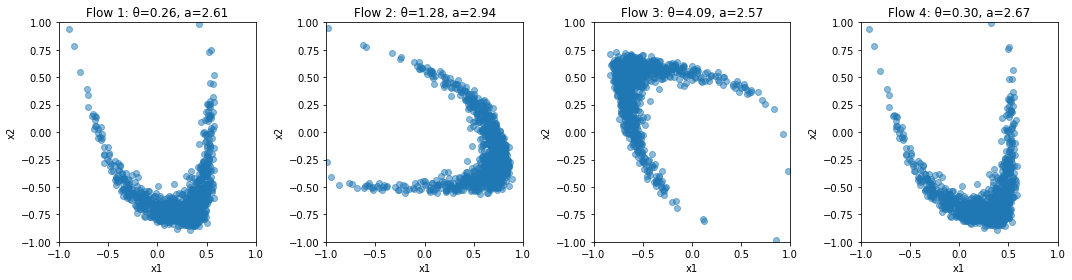

In [117]:
def visualize_flow(N, theta_samples, a_samples):
    base_samples = z.sample(N)

    fig, axes = plt.subplots(1, len(theta_samples), figsize=(15, 4))
    for i, (theta, a) in enumerate(zip(theta_samples, a_samples)):
     
        flow_bijector = create_flow(theta, a)
        
        
        transformed_samples = flow_bijector.forward(base_samples)
        
        
        axes[i].scatter(transformed_samples[:, 0], transformed_samples[:, 1], alpha=0.5)
        axes[i].set_xlim([-1, 1])
        axes[i].set_ylim([-1, 1])
        axes[i].set_title(f"Flow {i+1}: θ={theta:.2f}, a={a:.2f}")
        axes[i].set_xlabel("x1")
        axes[i].set_ylabel("x2")

    plt.tight_layout()
    plt.show()


N = 1000  
theta_samples = tf.random.uniform(shape=[4], minval=0, maxval=2 * np.pi) 
a_samples = tf.random.normal(shape=[4], mean=3.0, stddev=1.0)  


visualize_flow(N, theta_samples, a_samples)

Here we have displayed clear scatter plot visualisations of our transformed distribution 𝑥=𝑓5(𝑓4(𝑓3(𝑓2(𝑓1(𝑧))))). Let's now see if we can create an image dataset that resembles these plots.

## Creating the image dataset
* We now use the random normalising flow to generate an image dataset of contour plots from our random normalising flow network. 
* First, we will display a sample of 4 contour plot images from our normalising flow network using 4 independently sampled sets of parameters. 
* Our dataset will consist of some 1000 images, stored in a numpy array of shape `(N, 36, 36, 3)`.  Each image in the dataset should correspond to a contour plot of a transformed distribution from a normalising flow with an independently sampled set of parameters $s, T, S, b$.
* Lastly, we will display a sample of 20 images from the final generated datase.

Here we will create some functions to generate an image dataset of contour plots, and display some examples which we hope will resemble the scatter plot visualisations we have already created:

In [118]:
X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
inputs = np.transpose(np.stack((X, Y)), [1, 2, 0])

def get_densities(transformed_distribution):
    batch_shape = transformed_distribution.batch_shape
    Z = transformed_distribution.prob(np.expand_dims(inputs, 2))
    Z = np.transpose(Z, list(range(2, 2+len(batch_shape))) + [0, 1])
    return Z

In [119]:
def get_image_array_from_density_values(Z):
    assert Z.shape == (100, 100)
    fig = Figure(figsize=(0.5, 0.5))
    canvas = FigureCanvas(fig)
    ax = fig.gca()
    ax.contourf(X, Y, Z, cmap='hot', levels=100)
    ax.axis('off')
    fig.tight_layout(pad=0)

    ax.margins(0)
    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.float32)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image_from_plot

In [121]:
x1 = np.linspace(-1, 1, 100)  
x2 = np.linspace(-1, 1, 100)
X1, X2 = np.meshgrid(x1, x2)

def plot_density_contours(density, X1, X2, contour_kwargs, ax=None):
  
    X = np.hstack([X1.flatten()[:, np.newaxis], X2.flatten()[:, np.newaxis]])
    density_values = np.reshape(density(X).numpy(), newshape=X1.shape)
    
    if ax is None:
        _, ax = plt.subplots(figsize=(7, 7))
    
    ax.contour(X1, X2, density_values, **contour_kwargs)
    return ax

def display_contour_plots():
    theta_samples = tf.random.uniform([4], minval=0, maxval=2 * np.pi).numpy()
    a_samples = tf.random.normal([4], mean=3.0, stddev=1.0).numpy()
    
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    for i, (theta, a) in enumerate(zip(theta_samples, a_samples)):
        flow_bijector = create_flow(theta, a)
        
        transformed_distribution = tfd.TransformedDistribution(
            distribution=z, bijector=flow_bijector
        )
        
        
        ax = axes[i]
        plot_density_contours(
            density=transformed_distribution.prob, 
            X1=X1, 
            X2=X2, 
            contour_kwargs={'levels': np.linspace(1e-4, 0.1, 20), 'cmap': 'hot'}, 
            ax=ax
        )
        ax.set_title(f"θ={theta:.2f}, a={a:.2f}")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

In [122]:
def create_image_dataset(N, num_images):
    image_dataset = np.zeros((num_images, 36, 36, 3), dtype=np.uint8)
    
    x1 = np.linspace(-1, 1, 100)
    x2 = np.linspace(-1, 1, 100)
    X1, X2 = np.meshgrid(x1, x2)
    X = np.hstack([X1.flatten()[:, np.newaxis], X2.flatten()[:, np.newaxis]]) 
    
    for i in range(num_images):
        theta = tf.random.uniform([], minval=0, maxval=2 * np.pi).numpy()
        a = tf.random.normal([], mean=3.0, stddev=1.0).numpy()
        
        flow_bijector = create_flow(theta, a)
        transformed_distribution = tfd.TransformedDistribution(
            distribution=z, bijector=flow_bijector
        )
        
        density_values = np.reshape(
            transformed_distribution.prob(X).numpy(), newshape=X1.shape
        )
        
        fig, ax = plt.subplots(figsize=(0.5, 0.5))
        ax.contourf(X1, X2, density_values, cmap='hot', levels=np.linspace(1e-4, 0.1, 20))
        ax.axis('off')
        
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig) 
        
        image_dataset[i] = resize(image, (36, 36), preserve_range=True).astype(np.uint8)
    
    return image_dataset

In [123]:
def display_sample_images(image_dataset, num_samples=20):
    fig, axes = plt.subplots(4, 5, figsize=(10, 8))
    for i, ax in enumerate(axes.flatten()):
        if i < num_samples:
            ax.imshow(image_dataset[i])
            ax.axis("off")
    plt.tight_layout()
    plt.show()  

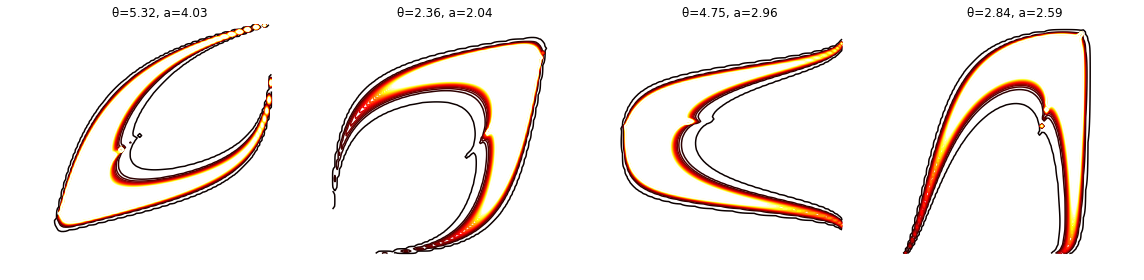

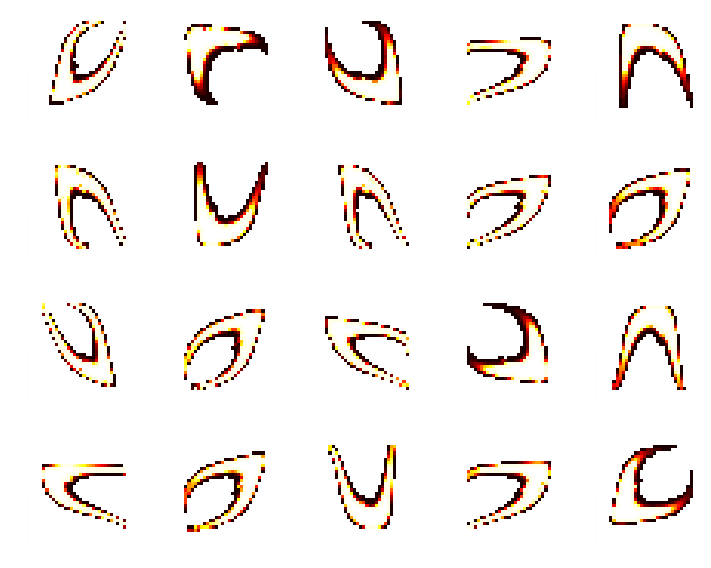

In [124]:
display_contour_plots()

N = 1000  
num_images = 1000  
image_dataset = create_image_dataset(N, num_images)

display_sample_images(image_dataset, num_samples=20)

Here we have displayed some images from our dataset, and they really do seem to closely resemble our scatter plots from our transformed distribution 𝑥=𝑓5(𝑓4(𝑓3(𝑓2(𝑓1(𝑧))))). We are on the right track.

## Making `tf.data.Dataset` objects
* We now split the dataset to create `tf.data.Dataset` objects for training and validation data. 
* Using the `map` method, we normalise the pixel values so that they lie between 0 and 1.
* These Datasets will be used to train a variational autoencoder (VAE). 
* We randomly shuffle the training Dataset and batch both datasets with a batch size of 20, setting `drop_remainder=True`.
* Lastly, we will display the `element_spec` property for one of the Dataset objects.

We will opt for an 80/20 training split, then shuffle and batch our data:

In [125]:
train_size = int(0.8 * len(image_dataset))
val_size = len(image_dataset) - train_size

dataset = tf.data.Dataset.from_tensor_slices(image_dataset)

dataset = dataset.shuffle(len(image_dataset))

In [126]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [127]:
def preprocess_image(image):
    image = tf.cast(image, tf.float32) / 255.0  
    return (image, image)  

train_dataset = train_dataset.map(preprocess_image)
val_dataset = val_dataset.map(preprocess_image)

In [128]:
batch_size = 20
train_dataset = train_dataset.shuffle(train_size).batch(batch_size, drop_remainder=True)
val_dataset = val_dataset.batch(batch_size, drop_remainder=True)

In [129]:
print("Element spec of training dataset:", train_dataset.element_spec)

Element spec of training dataset: (TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None), TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None))


This element spec lines up with our previous assumptions regarding parameters 𝑠,𝑇,𝑆,𝑏 and shape (N, 36, 36, 3). We will now pass our dataset objects to our model.

## Building the encoder and decoder networks
* We will now create the encoder and decoder for the variational autoencoder algorithm.
* We will design these networks subject to the following constraints:
   * The encoder and decoder networks will be built using the `Sequential` class.
   * The encoder and decoder networks will use probabilistic layers where necessary.
   * The prior distribution will be a zero-mean, isotropic Gaussian (identity covariance matrix).
   * The encoder network will implement KL divergence loss to the model.
* We will then display the model summary for the encoder and decoder networks.

First we will build an encoder, in effect compressing the important features of our image dataset through a bottleneck from which the decoder model will attempt to reconstruct similar (ideally identical) images. 

In [131]:
latent_size = 4  
input_shape = (36, 36, 3)  
prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_size))  

In [132]:
divergence_regularizer = tfpl.KLDivergenceRegularizer(
    prior,
    use_exact_kl=False,
    test_points_fn=lambda q: q.sample(10),
    test_points_reduce_axis=0
)

In [133]:
encoder = Sequential([
    Conv2D(32, (3, 3), strides=2, padding='same', input_shape=input_shape),
    BatchNormalization(),
    LeakyReLU(),
    Conv2D(64, (3, 3), strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    Flatten(),
    Dense(256),
    LeakyReLU(),
    Dense(tfpl.MultivariateNormalTriL.params_size(latent_size)),  
    tfpl.MultivariateNormalTriL(
        latent_size,
        activity_regularizer=divergence_regularizer) 
])

In [134]:
decoder = Sequential([
    Dense(256, activation='relu', input_shape=(latent_size,)),
    Dense(9 * 9 * 64, activation='relu'),
    Reshape((9, 9, 64)),
    Conv2DTranspose(32, (3, 3), strides=2, padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2DTranspose(3, (3, 3), strides=2, padding='same'),  
    Flatten(),
    tfpl.IndependentBernoulli(input_shape)
])

In [135]:
print("Encoder Summary:")
encoder.summary()

print("\nDecoder Summary:")
decoder.summary()

Encoder Summary:
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 18, 18, 32)        896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 18, 18, 32)        128       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 9, 9, 64)          256       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 5

Our models are relatively simple at some 2.7 million parameters in total, employing some probabilistic layers and convolution for feature extraction. Let's see if this network design will give us good reconstructions of images from the image dataset that we have created from our random normalising flow.

## Training the variational autoencoder
* We now train the variational autoencoder. We will build the VAE using the `Model` class.
* Next we compile the VAE with the negative log likelihood loss and train with the `fit` method, using the training and validation datasets.
* We will display model summaries and plot the learning curves for loss vs epoch for both training and validation sets.

We will now combine our encoder and decoder networks into a variational autoencoder, and train it using the `fit` method before evaluating the model's training and validation loss.

In [136]:
def negative_log_likelihood(y_true, y_pred):
    return -tf.reduce_mean(y_pred.log_prob(y_true))

In [137]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        latent_distribution = self.encoder(inputs)
        latent_sample = latent_distribution.sample()
        reconstructed_distribution = self.decoder(latent_sample)
        return reconstructed_distribution

In [138]:
vae = VAE(encoder, decoder)

In [139]:
vae.compile(optimizer=Adam(learning_rate=1e-3), loss=negative_log_likelihood)

In [140]:
print("\nVAE Model Summary:")
encoder.summary()
decoder.summary()


VAE Model Summary:
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 18, 18, 32)        896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 18, 18, 32)        128       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 9, 9, 64)          256       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None

In [141]:
history = vae.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    verbose=1)

Train for 40 steps, validate for 10 steps
Epoch 1/50
40/40 [==============================] - 15s 378ms/step - loss: 1922.6759 - val_loss: 2252.6147
Epoch 2/50
40/40 [==============================] - 10s 260ms/step - loss: 1194.2390 - val_loss: 1684.9511
Epoch 3/50
40/40 [==============================] - 10s 257ms/step - loss: 1001.6765 - val_loss: 1257.5249
Epoch 4/50
40/40 [==============================] - 10s 258ms/step - loss: 903.5691 - val_loss: 1039.3695
Epoch 5/50
40/40 [==============================] - 10s 260ms/step - loss: 852.4054 - val_loss: 949.1217
Epoch 6/50
40/40 [==============================] - 11s 273ms/step - loss: 798.7062 - val_loss: 866.5493
Epoch 7/50
40/40 [==============================] - 10s 260ms/step - loss: 766.3411 - val_loss: 801.9178
Epoch 8/50
40/40 [==============================] - 10s 260ms/step - loss: 741.4550 - val_loss: 748.8827
Epoch 9/50
40/40 [==============================] - 11s 263ms/step - loss: 707.0620 - val_loss: 748.4221
Epoch 

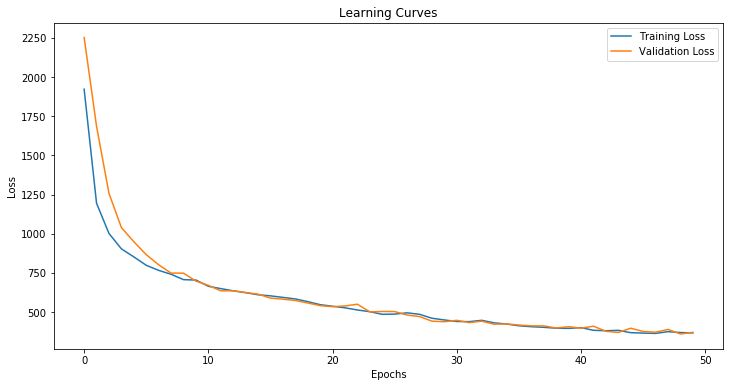

In [142]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curves')
    plt.legend()
    plt.show()
    
plot_learning_curves(history)

The validation and training loss appear to be behaving as expected, and track each other quite closely. This indicates that we have likely trained our model well, but we can't know for sure - lets put it to the test!

## Using the encoder and decoder networks
* We can now put our encoder and decoder networks into practice!
* We will randomly sample 1000 images from the dataset, and pass them through the encoder. Next we display the embeddings in a scatter plot (projected to 2 dimensions).
* We then randomly sample 4 images from the dataset and for each image, displaying the original and reconstructed images from the VAE.
* Lastly, we will randomly sample 6 latent variable realisations from the prior distribution, and display the images in a figure.

In [144]:
random_indices = np.random.choice(len(image_dataset), size=1000, replace=False)
random_samples = image_dataset[random_indices].astype(np.float32) / 255.0  

In [ ]:
encoded_distributions = encoder(random_samples)
encoded_samples = encoded_distributions.sample().numpy()

In [145]:
if encoded_samples.shape[1] > 2:
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    projected_samples = pca.fit_transform(encoded_samples)
else:
    projected_samples = encoded_samples

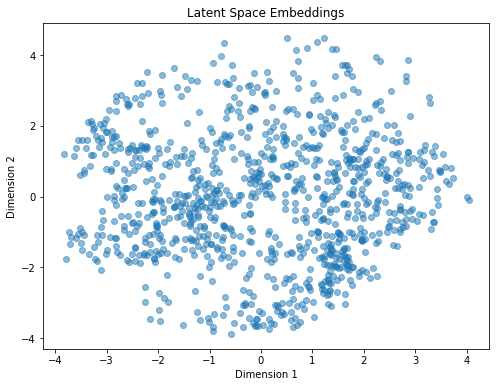

In [146]:
plt.figure(figsize=(8, 6))
plt.scatter(projected_samples[:, 0], projected_samples[:, 1], alpha=0.5)
plt.title("Latent Space Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

Now, we will sample and display some images and reconstructions:

In [ ]:
random_indices = np.random.choice(len(image_dataset), size=4, replace=False)
random_images = image_dataset[random_indices].astype(np.float32) / 255.0  

In [ ]:
reconstructed_distributions = vae(random_images)
reconstructed_images = reconstructed_distributions.mean().numpy()
reconstructed_images = np.clip(reconstructed_images * 255, 0, 255).astype(np.uint8)

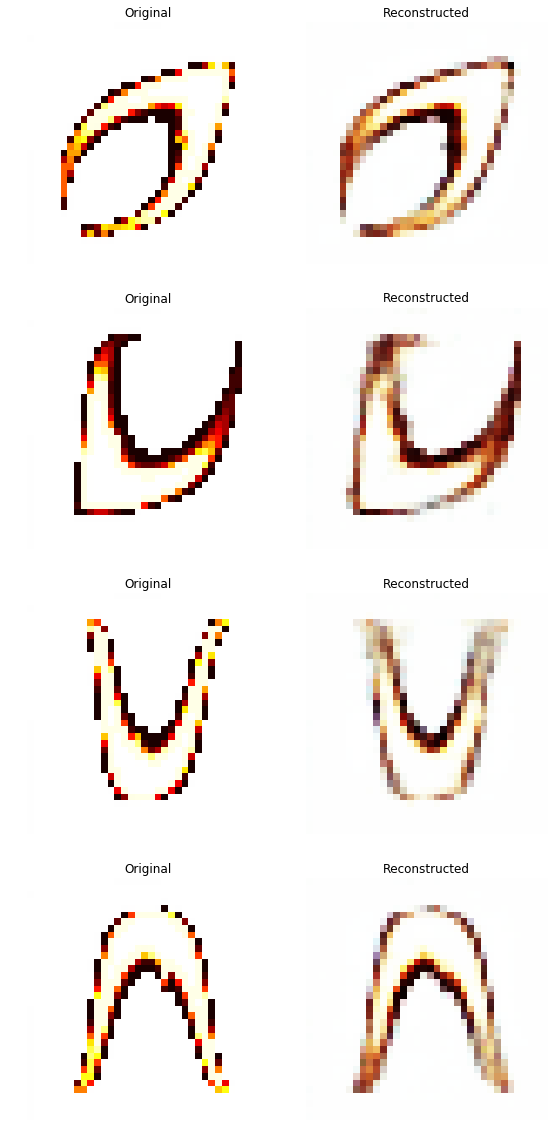

In [147]:
fig, axes = plt.subplots(4, 2, figsize=(8, 16))
for i, (original, reconstructed) in enumerate(zip(random_images, reconstructed_images)):
    axes[i, 0].imshow(original)  
    axes[i, 0].set_title("Original")
    axes[i, 0].axis("off")
    
    axes[i, 1].imshow(reconstructed)  
    axes[i, 1].set_title("Reconstructed")
    axes[i, 1].axis("off")
plt.tight_layout()
plt.show()

In [ ]:
latent_samples = prior.sample(6).numpy()
generated_distributions = decoder(latent_samples)

In [ ]:
generated_images = generated_distributions.mean().numpy()
generated_images = np.clip(generated_images * 255, 0, 255).astype(np.uint8)

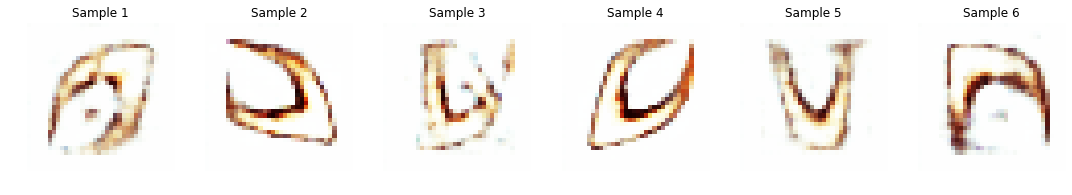

In [148]:
fig, axes = plt.subplots(1, 6, figsize=(15, 4))
for i, generated_image in enumerate(generated_images):
    axes[i].imshow(generated_image)
    axes[i].set_title(f"Sample {i + 1}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()

Our variational autoencoder algorithm seems to have accurately reconstructed the original images that we created with our random normalising flow! With added model complexity and additional training, even more complex images could be even more accurately reconstructed in a similar manner! 

## A video of latent space interpolation 
* Just for fun, you can run the code below to create a video of our decoder's generations, depending on the latent space.

In [149]:
def get_animation(latent_size, decoder, interpolation_length=500):
    assert latent_size >= 2, "Latent space must be at least 2-dimensional for plotting"
    fig = plt.figure(figsize=(9, 4))  
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_xlim([-3, 3])
    ax1.set_ylim([-3, 3])
    ax1.set_title("Latent space")
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title("Data space")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)

    # initializing a line variable 
    line, = ax1.plot([], [], marker='o')
    img2 = ax2.imshow(np.zeros((36, 36, 3)))

    freqs = np.random.uniform(low=0.1, high=0.2, size=(latent_size,))
    phases = np.random.randn(latent_size)
    input_points = np.arange(interpolation_length)
    latent_coords = []
    for i in range(latent_size):
        latent_coords.append(2 * np.sin((freqs[i]*input_points + phases[i])).astype(np.float32))

    def animate(i): 
        z = tf.constant([coord[i] for coord in latent_coords])
        img_out = np.squeeze(decoder(z[np.newaxis, ...]).mean().numpy())
        line.set_data(z.numpy()[0], z.numpy()[1])
        img2.set_data(np.clip(img_out, 0, 1))
        return (line, img2)

    return anim.FuncAnimation(fig, animate, frames=interpolation_length, 
                              repeat=False, blit=True, interval=150)

Run the following code to create the animation:

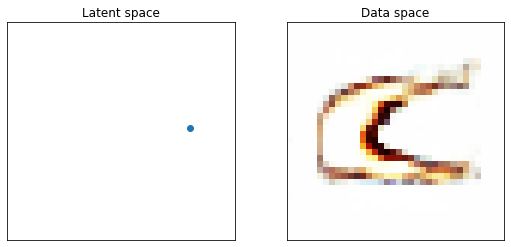

In [150]:
a = get_animation(latent_size, decoder, interpolation_length=200)
HTML(a.to_html5_video())